In [1]:
import os
import gc
import psutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from multiprocessing import Pool
import lightgbm as lgb
from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)
print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
      ' | device num:', os.environ['CUDA_VISIBLE_DEVICES'])

available GPU devices: 1  | device num: 0


In [2]:
SEED = 80
DATA_DIR = './data'
MODELS_DIR = './models'
MODEL_VER = 'v0'
CUT_DATE = '2011-01-01'
END_D = 1913
PRED_FWD = 28
N_CORES = int(psutil.cpu_count() * .75)
print('num pf cores:', N_CORES)
#---|CUT_DATE|---train---|END_D - PRED_FWD|--val--|END_D|--forecast-->|END_D + PRED_FWD|

num pf cores: 24


In [3]:
CALENDAR_DTYPES = {
    'date':             'str',
    'wm_yr_wk':         'int16', 
    'weekday':          'object',
    'wday':             'int8', 
    'month':            'int8', 
    'year':             'int16', 
    'd':                'object',
    'event_name_1':     'object',
    'event_type_1':     'object',
    'event_name_2':     'object',
    'event_type_2':     'object',
    'snap_CA':          'int8', 
    'snap_TX':          'int8', 
    'snap_WI':          'int8'
}
PARSE_DATES = ['date']
SPRICES_DTYPES = {
    'store_id':    'object', 
    'item_id':     'object', 
    'wm_yr_wk':    'int16',  
    'sell_price':  'float16'
}
DROP_COLS = ['id', 'sales', 'date', 'wm_yr_wk', 'weekday', 'wday']
CAT_COLS = [
    'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI'
]

In [4]:
def get_df():
    print('-' * 10, 'BASE GRID', '-' * 10)
    strain = pd.read_csv('{}/sales_train_validation.csv'.format(DATA_DIR))
    print('read train:', strain.shape)
    for day in range(END_D + 1, END_D + PRED_FWD + 1):
        strain['d_{}'.format(day)] = np.nan
    strain = pd.melt(
        strain,
        id_vars = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id'],
        value_vars = [col for col in strain.columns if col.startswith('d_')],
        var_name = 'd',
        value_name = 'sales'
    )
    print('melted train:', strain.shape)
    calendar = pd.read_csv('{}/calendar.csv'.format(DATA_DIR), dtype=CALENDAR_DTYPES, parse_dates=PARSE_DATES)
    print('read calendar:', calendar.shape)
    strain = strain.merge(calendar, on='d', copy=False)
    strain.drop(columns=['month', 'year'], inplace=True)
    strain['d'] = strain['d'].apply(lambda x: int(x.replace('d_', '')))  
    print('calendar merge done')
    strain['tm_d'] = strain['date'].dt.day.astype(np.int8)
    strain['tm_w'] = strain['date'].dt.week.astype(np.int8)
    strain['tm_m'] = strain['date'].dt.month.astype(np.int8)
    strain['tm_y'] = strain['date'].dt.year
    strain['tm_y'] = (strain['tm_y'] - strain['tm_y'].min()).astype(np.int8)
    strain['tm_wm'] = strain['tm_d'].apply(lambda x: np.ceil(x / 7)).astype(np.int8)
    strain['tm_dw'] = strain['date'].dt.dayofweek.astype(np.int8)
    strain['tm_w_end'] = (strain['tm_dw'] >= 5).astype(np.int8)
    print('date features done')
    sprices = pd.read_csv('{}/sell_prices.csv'.format(DATA_DIR), dtype=SPRICES_DTYPES)
    print('read prices:', sprices.shape)
    sprices['price_max'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('max')
    sprices['price_min'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('min')
    sprices['price_std'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('std')
    sprices['price_mean'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('mean')
    sprices['price_norm'] = sprices['sell_price'] / sprices['price_max']
    sprices['price_nunique'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('nunique')
    sprices['item_nunique'] = sprices.groupby(['store_id', 'sell_price'])['item_id'].transform('nunique')
    calendar_prices = calendar[['wm_yr_wk', 'month', 'year']]
    calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
    sprices = sprices.merge(calendar_prices[['wm_yr_wk', 'month', 'year']], on=['wm_yr_wk'], how='left')
    del calendar, calendar_prices
    sprices['price_momentum'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id']
    )['sell_price'].transform(lambda x: x.shift(1))
    sprices['price_momentum_m'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'month']
    )['sell_price'].transform('mean')
    sprices['price_momentum_y'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'year']
    )['sell_price'].transform('mean')
    strain = strain.merge(
        sprices, 
        on=['store_id', 'item_id', 'wm_yr_wk'], 
        copy=False
    )
    strain.drop(columns=['month', 'year'], inplace=True)
    del sprices
    print('prices merge done')
    for col in CAT_COLS:
        strain[col]= strain[col].astype('category')
        strain[col] = strain[col].cat.codes.astype('int16')
        strain[col] -= strain[col].min()
    print('cols to category done')
    print('begin train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    strain = strain.loc[strain['date'] >= CUT_DATE]
    print('date cut train:', strain.shape)
    print('cut train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    gc.collect()
    return strain

In [136]:
def make_features_adv(strain):
    print('-' * 10, 'ADVANCED FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    icols =  [
        ['state_id'],
        ['store_id'],
        ['cat_id'],
        ['dept_id'],
        ['state_id', 'cat_id'],
        ['state_id', 'dept_id'],
        ['store_id', 'cat_id'],
        ['store_id', 'dept_id'],
        ['item_id'],
        ['item_id', 'state_id'],
        ['item_id', 'store_id']
    ]
    cols = list(set([item for sublist in icols for item in sublist]))
    cols.extend(['d', 'sales'])
    df_temp = strain[cols].copy()
    df_temp.loc[df_temp['d'] > (END_D - PRED_FWD), 'sales'] = np.nan
    for col in icols:
        col_name = '_{}_'.format('_'.join(col))
        strain['enc{}mean'.format(col_name)] = df_temp.groupby(col)['sales'].transform('mean').astype(np.float16)
        strain['enc{}std'.format(col_name)] = df_temp.groupby(col)['sales'].transform('std').astype(np.float16)
    print('encoding done')
    del df_temp
    gc.collect()
    return strain

In [137]:
def make_features_lag(strain):
    print('-' * 10, 'LAG AND ROLL FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    lags = range(PRED_FWD, PRED_FWD + 14 + 1)
    lag_cols = ['lag_{}'.format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        strain[lag_col] = strain[['id', 'sales']].groupby(['id'])['sales'].shift(lag).astype(np.float16)
    print('lag sales done')
    for roll in [7, 14, 30, 60, 180]:
        roll_col = 'lag_{}_roll_mean_{}'.format(PRED_FWD, roll)
        strain[roll_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
            lambda x: x.shift(PRED_FWD).rolling(roll).mean()
        ).astype(np.float16)
        roll_col = 'lag_{}_roll_std_{}'.format(PRED_FWD, roll)
        strain[roll_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
            lambda x: x.shift(PRED_FWD).rolling(roll).std()
        ).astype(np.float16)
    print('roll mean and std sales done')
    print('out dataframe:', strain.shape)
    return strain

In [154]:
def make_features_last_sales(strain):
    print('-' * 10, 'LAST SALES FEATURE', '-' * 10)
    print('in dataframe:', strain.shape)
    n_day = 1    
    last_sales = strain[['id', 'd', 'sales']].copy()
    last_sales['non_zero'] = (last_sales['sales'] > 0).astype(np.int8)
    last_sales['non_zero_lag'] = last_sales.groupby(['id'])['non_zero'].transform(
        lambda x: x.shift(n_day).rolling(2000, 1).sum()
    ).fillna(-1)
    df_temp = last_sales[['id', 'd', 'non_zero_lag']].drop_duplicates(subset=['id', 'non_zero_lag'])
    df_temp.columns = ['id', 'd_min', 'non_zero_lag']
    last_sales = last_sales.merge(df_temp, on=['id', 'non_zero_lag'], how='left')
    strain.loc[:, 'last_sale'] = (last_sales['d'] - last_sales['d_min']).astype(np.int16)
    del last_sales, df_temp
    gc.collect()
    print('last non zero sales done')
    print('out dataframe:', strain.shape)
    return strain

In [155]:
def make_features_win(strain):
    print('-' * 10, 'WIN ROLL FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    lags = [1, 7, 14]
    windows= [7, 14, 30, 60]
    for lag in lags:
        for wnd in windows:
            wnd_col = 'lag_{}_roll_mean_{}'.format(lag, wnd)
            strain[wnd_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
                lambda x: x.shift(lag).rolling(wnd).mean().astype(np.float16)
            )
    print('window roll mean sales done')
    print('out dataframe:', strain.shape)
    return strain

In [8]:
%%time
strain = get_df()
strain = make_features_adv(strain)
strain = make_features_lag(strain)
strain = make_features_last_sales(strain)
strain = make_features_win(strain)

---------- BASE GRID ----------
read train: (30490, 1919)
melted train: (59181090, 8)
read calendar: (1969, 14)
calendar merge done
date features done
read prices: (6841121, 4)
prices merge done
cols to category done
begin train date: 2011-01-29 00:00:00
end train date: 2016-05-22 00:00:00
date cut train: (46881677, 37)
cut train date: 2011-01-29 00:00:00
end train date: 2016-05-22 00:00:00
---------- ADVANCED FEATURES ----------
in dataframe: (46881677, 37)
last non zero sales done
encoding done
---------- LAG AND ROLL FEATURES ----------
in dataframe: (46881677, 60)
lag sales done
roll mean and std sales done
out dataframe: (46881677, 85)
---------- WIN ROLL FEATURES ----------
in dataframe: (46881677, 85)
window roll mean sales done
out dataframe: (46881677, 97)
CPU times: user 12min 59s, sys: 1min 8s, total: 14min 7s
Wall time: 14min 8s


from 2011-01-29 00:00:00 to 2016-05-22 00:00:00


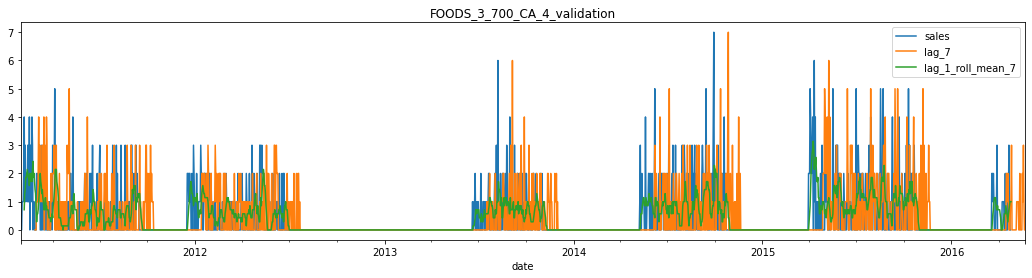

In [9]:
id_name = np.random.choice(strain['id'].unique())
id_sales = strain.loc[strain['id'] == id_name].set_index('date')
print('from', strain['date'].min(), 'to', strain['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales['lag_28'].plot(label='lag_7')
id_sales['lag_1_roll_mean_7'].plot(label='lag_1_roll_mean_7')
plt.title(id_name)
plt.legend()
plt.show()

In [10]:
train_cols = strain.columns[~strain.columns.isin(DROP_COLS)]
store_ids = list(strain['store_id'].unique())
print('stores', store_ids)

stores [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [11]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': .5,
    'subsample_freq': 1,
    'learning_rate': .03,
    'num_leaves': 2 ** 11 - 1,
    'min_data_in_leaf': 2 ** 12 - 1,
    'feature_fraction': .5,
    'max_bin': 100,
    'n_estimators': 1400,
    'boost_from_average': False,
    'verbose': 1,
    'nthread' : N_CORES,
    #'early_stopping_rounds': 40,
    'seed': SEED
}
for store_id in tqdm(store_ids):
    print('-' * 10, 'store training:', store_id, '-' * 10)
    X_train = strain[
        (strain['d'] <= END_D) &
        (strain['store_id'] == store_id)
    ][train_cols]
    y_train = strain[
        (strain['d'] <= END_D) &
        (strain['store_id'] == store_id)
    ]['sales']
    X_val = strain[
        (strain['d'] > (END_D - PRED_FWD)) & 
        (strain['d'] <= END_D) &
        (strain['store_id'] == store_id)
    ][train_cols]
    y_val = strain[
        (strain['d'] > (END_D - PRED_FWD)) & 
        (strain['d'] <= END_D) &
        (strain['store_id'] == store_id)
    ]['sales']
    print('train shapes:', X_train.shape, len(y_train))
    print('val shapes:', X_val.shape, len(y_val))
    train_lgb = lgb.Dataset(X_train, label=y_train, categorical_feature=CAT_COLS, free_raw_data=False)
    val_lgb = lgb.Dataset(X_val, label=y_val, categorical_feature=CAT_COLS, free_raw_data=False)
    del X_train, y_train, X_val, y_val
    gc.collect()
    model = lgb.train(lgb_params, train_lgb, valid_sets=[val_lgb], verbose_eval=40) 
    model_file = '{}/model_{}_store_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id)
    model.save_model(model_file)
    print('save to file:', model_file)

---------- store training: 0 ----------
train shapes: (4702895, 91) 4702895
val shapes: (85372, 91) 85372


/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[40]	valid_0's rmse: 2.26357
[80]	valid_0's rmse: 2.03093
[120]	valid_0's rmse: 2.01931
[160]	valid_0's rmse: 2.01436
[200]	valid_0's rmse: 2.00757
[240]	valid_0's rmse: 1.99851
[280]	valid_0's rmse: 1.99266
[320]	valid_0's rmse: 1.98797
[360]	valid_0's rmse: 1.98441
[400]	valid_0's rmse: 1.98027
[440]	valid_0's rmse: 1.97671
[480]	valid_0's rmse: 1.97394
[520]	valid_0's rmse: 1.97083
[560]	valid_0's rmse: 1.96867
[600]	valid_0's rmse: 1.96622
[640]	valid_0's rmse: 1.96408
[680]	valid_0's rmse: 1.96174
[720]	valid_0's rmse: 1.95921
[760]	valid_0's rmse: 1.95697
[800]	valid_0's rmse: 1.95484
[840]	valid_0's rmse: 1.95284
[880]	valid_0's rmse: 1.9509
[920]	valid_0's rmse: 1.94828
[960]	valid_0's rmse: 1.94606
[1000]	valid_0's rmse: 1.9442
[1040]	valid_0's rmse: 1.94165
[1080]	valid_0's rmse: 1.94001
[1120]	valid_0's rmse: 1.93837
[1160]	valid_0's rmse: 1.9362
[1200]	valid_0's rmse: 1.93453
[1240]	valid_0's rmse: 1.93284
[1280]	valid_0's rmse: 1.93131
[1320]	valid_0's rmse: 1.92968
[1360]

[1320]	valid_0's rmse: 1.61534
[1360]	valid_0's rmse: 1.6138
[1400]	valid_0's rmse: 1.61245
save to file: ./models/model_v0_store_6.lgb
---------- store training: 7 ----------
train shapes: (4475395, 91) 4475395
val shapes: (85372, 91) 85372
[40]	valid_0's rmse: 1.7528
[80]	valid_0's rmse: 1.60424
[120]	valid_0's rmse: 1.58219
[160]	valid_0's rmse: 1.57561
[200]	valid_0's rmse: 1.57092
[240]	valid_0's rmse: 1.56706
[280]	valid_0's rmse: 1.56384
[320]	valid_0's rmse: 1.56115
[360]	valid_0's rmse: 1.55863
[400]	valid_0's rmse: 1.55591
[440]	valid_0's rmse: 1.55388
[480]	valid_0's rmse: 1.55179
[520]	valid_0's rmse: 1.55013
[560]	valid_0's rmse: 1.54794
[600]	valid_0's rmse: 1.54604
[640]	valid_0's rmse: 1.54444
[680]	valid_0's rmse: 1.54317
[720]	valid_0's rmse: 1.54135
[760]	valid_0's rmse: 1.53975
[800]	valid_0's rmse: 1.53832
[840]	valid_0's rmse: 1.53668
[880]	valid_0's rmse: 1.53539
[920]	valid_0's rmse: 1.53397
[960]	valid_0's rmse: 1.53259
[1000]	valid_0's rmse: 1.53146
[1040]	val

In [12]:
store_id = 0
model_file = '{}/model_{}_store_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id)
model = lgb.Booster(model_file=model_file)

In [13]:
feat_importances = sorted(
    [(f, v) for f, v in zip(train_cols, model.feature_importance())],
    key=lambda x: x[1],
    reverse=True
)

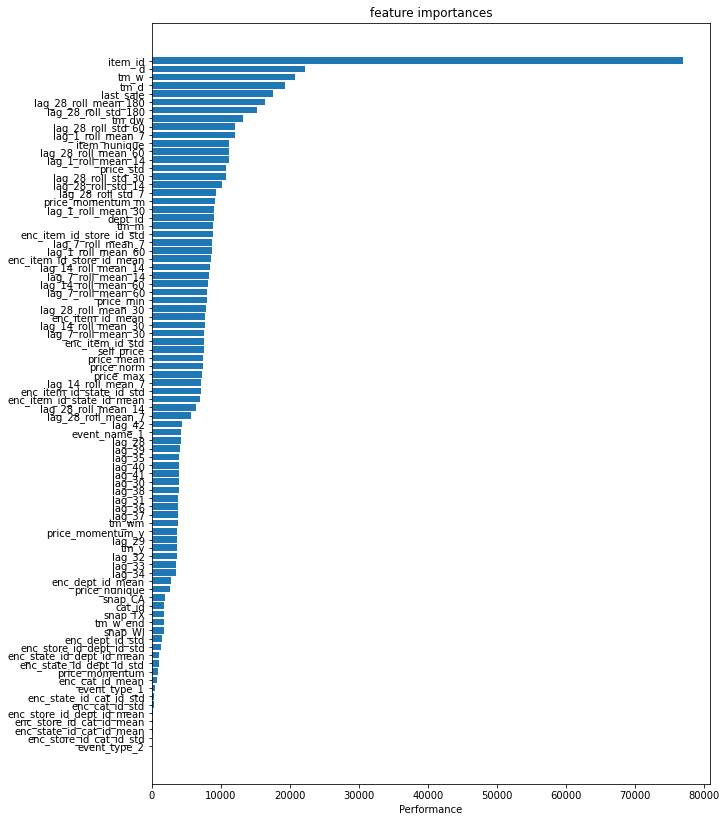

In [14]:
fig, ax = plt.subplots(figsize=(10, 14))
labels, values = [x[0] for x in feat_importances if x[1] > .5], [x[1] for x in feat_importances if x[1] > .5]
y_pos = np.arange(len(labels))
ax.barh(y_pos, values)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel('Performance')
ax.set_title('feature importances')
plt.show()

In [101]:
%%time
spred_val = strain[
    (strain['d'] > (END_D - PRED_FWD)) &
    (strain['d'] <= END_D) &
    (strain['store_id'] == store_id)
].copy()
preds_val = model.predict(spred_val[train_cols])
print(len(spred_val))
spred_val.loc[:, 'sales_val'] = preds_val
spred_bck = strain[
    (strain['d'] > (END_D - 2 * PRED_FWD)) &
    (strain['d'] <= (END_D - PRED_FWD)) &
    (strain['store_id'] == store_id)
].copy()
preds_bck = model.predict(spred_bck[train_cols])
print(len(preds_bck))
spred_val.loc[:, 'sales_bck'] = preds_bck

85372
85372
CPU times: user 5min 2s, sys: 40 ms, total: 5min 2s
Wall time: 13.3 s


id to draw: HOBBIES_1_065_WI_3_validation
from 2011-01-29 00:00:00 to 2016-05-22 00:00:00


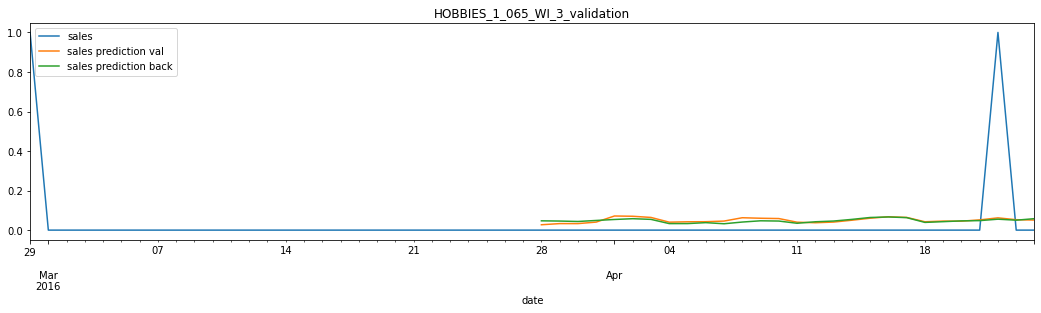

In [104]:
id_name = np.random.choice(strain[strain['store_id'] == store_id]['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > (END_D - 2 * PRED_FWD)) &
    (strain['d'] <= END_D) &
    (strain['store_id'] == store_id)
].set_index('date')
id_sales_pred_val = spred_val.loc[spred_val['id'] == id_name].set_index('date')
print('from', strain['date'].min(), 'to', strain['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred_val['sales_val'].plot(label='sales prediction val')
id_sales_pred_val['sales_bck'].plot(label='sales prediction back')
plt.title(id_name)
plt.legend()
plt.show()

In [142]:
spred = strain[strain['d'] > (END_D - 100)].copy()

In [ ]:
for pred_d in tqdm(range(1, PRED_FWD + 1)):
    print('=' * 10, 'forecast day forward:', pred_d, '=' * 10) 
    strain = make_features_last_sales(strain)
    spred = strain[strain['d'] > (END_D - 100)].copy()
    spred = make_features_win(spred)
    for store_id in store_ids:
        model_file = '{}/model_{}_store_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id)
        model = lgb.Booster(model_file=model_file)
        strain.loc[
            (strain['d'] == (END_D + pred_d)) & (strain['store_id'] == store_id), 
            'sales'
        ] = model.predict(
            spred.loc[
                (spred['d'] == (END_D + pred_d)) & (spred['store_id'] == store_id), 
                train_cols
            ]
        )
        print('store predicted:', store_id, '| model:', model_file)
    all_sales = strain[strain['d'] == (END_D + pred_d)]['sales'].values
    print('day forward:', END_D + pred_d, 'all sales:', np.sum(all_sales))

========== forecast day forward: 1 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (46881677, 97)
last non zero sales done
out dataframe: (46881677, 97)
---------- WIN ROLL FEATURES ----------
in dataframe: (3902440, 97)
window roll mean sales done
out dataframe: (3902440, 97)
store predicted: 0 | model: ./models/model_v0_store_0.lgb
store predicted: 1 | model: ./models/model_v0_store_1.lgb
store predicted: 2 | model: ./models/model_v0_store_2.lgb
store predicted: 3 | model: ./models/model_v0_store_3.lgb
store predicted: 4 | model: ./models/model_v0_store_4.lgb
store predicted: 5 | model: ./models/model_v0_store_5.lgb
store predicted: 6 | model: ./models/model_v0_store_6.lgb
store predicted: 7 | model: ./models/model_v0_store_7.lgb
store predicted: 8 | model: ./models/model_v0_store_8.lgb
store predicted: 9 | model: ./models/model_v0_store_9.lgb
day forward: 1914 all sales: 37478.79344072573
========== forecast day forward: 2 ==========
---------- LAST SALES FEATURE -

store predicted: 9 | model: ./models/model_v0_store_9.lgb
day forward: 1922 all sales: 45443.46230981544
========== forecast day forward: 10 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (46881677, 97)
last non zero sales done
out dataframe: (46881677, 97)
---------- WIN ROLL FEATURES ----------
in dataframe: (3902440, 97)
window roll mean sales done
out dataframe: (3902440, 97)
store predicted: 0 | model: ./models/model_v0_store_0.lgb
store predicted: 1 | model: ./models/model_v0_store_1.lgb
store predicted: 2 | model: ./models/model_v0_store_2.lgb
store predicted: 3 | model: ./models/model_v0_store_3.lgb
store predicted: 4 | model: ./models/model_v0_store_4.lgb
store predicted: 5 | model: ./models/model_v0_store_5.lgb
store predicted: 6 | model: ./models/model_v0_store_6.lgb
store predicted: 7 | model: ./models/model_v0_store_7.lgb
store predicted: 8 | model: ./models/model_v0_store_8.lgb
store predicted: 9 | model: ./models/model_v0_store_9.lgb
day forward: 1923 

store predicted: 7 | model: ./models/model_v0_store_7.lgb
store predicted: 8 | model: ./models/model_v0_store_8.lgb
store predicted: 9 | model: ./models/model_v0_store_9.lgb
day forward: 1931 all sales: 41738.98903356772
========== forecast day forward: 19 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (46881677, 97)
last non zero sales done
out dataframe: (46881677, 97)
---------- WIN ROLL FEATURES ----------
in dataframe: (3902440, 97)
window roll mean sales done
out dataframe: (3902440, 97)
store predicted: 0 | model: ./models/model_v0_store_0.lgb
store predicted: 1 | model: ./models/model_v0_store_1.lgb
store predicted: 2 | model: ./models/model_v0_store_2.lgb
store predicted: 3 | model: ./models/model_v0_store_3.lgb
store predicted: 4 | model: ./models/model_v0_store_4.lgb
store predicted: 5 | model: ./models/model_v0_store_5.lgb
store predicted: 6 | model: ./models/model_v0_store_6.lgb
store predicted: 7 | model: ./models/model_v0_store_7.lgb
store predicted: 8

id to draw: HOUSEHOLD_2_140_CA_1_validation
from 2016-01-16 00:00:00 to 2016-05-22 00:00:00


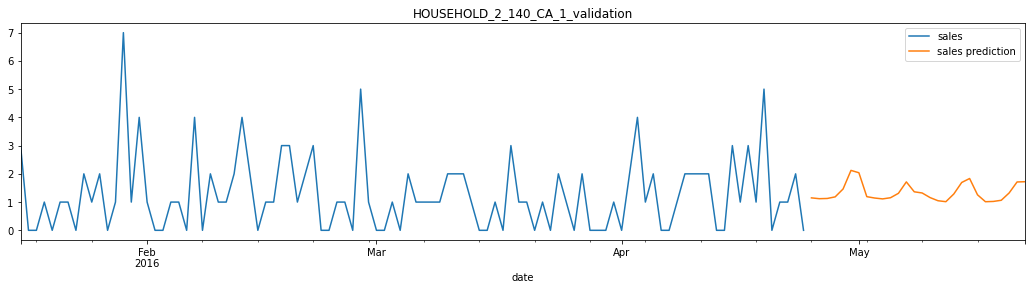

In [147]:
id_name = np.random.choice(spred['id'].unique())
print('id to draw:', id_name)
id_sales = spred.loc[(spred['id'] == id_name) & (spred['d'] <= END_D)].set_index('date')
id_sales_pred = spred.loc[(spred['id'] == id_name) & (spred['d'] > END_D)].set_index('date')
print('from', spred['date'].min(), 'to', spred['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales prediction')
plt.title(id_name)
plt.legend()
plt.show()

In [148]:
spred_subm = spred.loc[spred['d'] > END_D, ['id', 'd', 'sales']].copy()
spred_subm['d'] = spred_subm['d'].apply(lambda x: 'F{}'.format(x - END_D))
spred_subm.loc[spred_subm['sales'] < 0, 'sales'] = 0

In [149]:
f_cols = ['F{}'.format(x) for x in range(1, PRED_FWD + 1)]
spred_subm = spred_subm.set_index(['id', 'd']).unstack()['sales'][f_cols].reset_index()
spred_subm.fillna(0, inplace=True)
spred_subm.sort_values('id', inplace=True)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.head()

d,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.765088,0.721160,0.694534,0.753435,0.951677,0.983037,1.046588,0.848096,0.745387,0.835573,0.768621,0.959749,1.064658,0.882742,0.805039,0.651496,0.741318,0.700858,0.850115,0.965851,0.872584,0.728771,0.676196,0.676349,0.629497,0.792920,0.965911,0.786005
1,FOODS_1_001_CA_2_validation,0.951491,1.032915,1.049419,0.903185,1.156561,1.289880,1.699617,1.045716,1.124666,1.035411,1.077650,1.154723,1.371241,1.185803,1.026638,0.981254,0.978308,0.936166,1.118902,1.258062,1.270664,0.884845,1.004410,0.869501,0.934946,0.945143,1.177141,1.269604
2,FOODS_1_001_CA_3_validation,0.894910,1.067254,1.024339,0.970401,1.079745,1.447399,1.636336,0.872243,0.870257,0.811292,0.918105,0.974259,1.242118,1.438192,0.943178,0.870065,0.890200,0.860744,1.049191,1.397739,1.455579,0.889839,0.824334,0.917010,0.936240,1.083065,1.373250,1.496338
3,FOODS_1_001_CA_4_validation,0.307300,0.307659,0.286896,0.314983,0.298897,0.317566,0.359766,0.358188,0.333228,0.329080,0.327634,0.340238,0.374827,0.359958,0.377566,0.340397,0.380407,0.387160,0.359260,0.376214,0.355084,0.356015,0.323785,0.324679,0.364168,0.325276,0.338314,0.313413
4,FOODS_1_001_TX_1_validation,0.073331,0.429069,0.438238,0.427343,0.448347,0.599271,0.609817,0.451584,0.458541,0.395135,0.381712,0.414486,0.422239,0.489226,0.343109,0.361628,0.363564,0.382940,0.401785,0.428787,0.430960,0.395278,0.383517,0.361578,0.376104,0.384515,0.410845,0.455194


In [150]:
spred_subm_eval = spred_subm.copy()
spred_subm_eval['id'] = spred_subm_eval['id'].str.replace('validation', 'evaluation')
spred_subm = pd.concat([spred_subm, spred_subm_eval], axis=0, sort=False)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.to_csv('submission.csv', index=False)
print('submission saved:', spred_subm.shape)

submission saved: (60980, 29)
